In [1]:
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from multiprocessing import  Pool
import spacy
#!python -m spacy download en_core_web_md

In [2]:
train = pd.read_csv("/kaggle/input/d/yipeng07/fakenews/fulltrain.csv",header=None)
test = pd.read_csv("/kaggle/input/d/yipeng07/fakenews/balancedtest.csv",header=None)

## 1. Obtain the basic features

In [3]:
#Check the first 10 lines
train.head(10)

,0,1
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...
5,1,"At a cafeteria-table press conference Monday, ..."
6,1,Stunned shock and dismay were just a few of th...
7,1,"Speaking with reporters before a game Monday, ..."
8,1,Sports journalists and television crews were p...
9,1,"SALEM, VAF;or the eighth straight world-histor..."


In [4]:
#Change columns name
train.columns = ['Verdict','Text']

In [5]:
#Check the first 10 lines
test.head(10)

,0,1
0,1,When so many actors seem content to churn out ...
1,1,In what football insiders are calling an unex...
2,1,In a freak accident following Game 3 of the N....
3,1,North Koreas official news agency announced to...
4,1,The former Alaska Governor Sarah Palin would b...
5,1,With the first Presidential debate just two da...
6,1,"There are fans, and then there are super-fans...."
7,1,"With its landmark decisions this week, the Uni..."
8,1,Koch Industries is defending its acquisition o...
9,1,Republican lawmakers asked increasingly tough ...


In [6]:
#Change columns name
test.columns = ['Verdict','Text']

In [ ]:
#Word count
train['word_count'] = train['Text'].apply(lambda x: len(str(x).split(" ")))
train[['Text', 'word_count']].head()

In [ ]:
#Char count
train['char_count'] = train['Text'].str.len()
train[['Text','char_count']].head()

In [ ]:
#Average word length

def avg_word(sentence):
    words=sentence.split()
    return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['Text'].apply(lambda x:avg_word(x))
train[['Text','avg_word']].head()

In [ ]:
# The number of stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop=stopwords.words('english')
train['stopwords']=train['Text'].apply(lambda sen:len([x for x in sen.split() if x in stop]))
train[['Text','stopwords']].head()

In [ ]:
#The number of special chars
train['hashtags']=train['Text'].apply(lambda sen:len([x for x in sen.split() if x.startswith("#")]))
train[['Text','hashtags']].head()

In [ ]:
#The number of numerics
train['numerics']=train['Text'].apply(lambda sen:len([x for x in sen.split() if x.isdigit()]))
train[['Text','numerics']].head()

In [ ]:
#The number of upper vocab
train['upper']=train['Text'].apply(lambda sen:len([x for x in sen.split() if x.isupper()]))
train[['Text','upper']].head()

In [ ]:
train.head()

In [ ]:
#Delete HTML
from bs4 import BeautifulSoup
train['Text'] = train['Text'].apply(lambda x: BeautifulSoup(x,'html.parser').get_text())
test['Text'] = test['Text'].apply(lambda x: BeautifulSoup(x,'html.parser').get_text())
test['Text'].head()

#Remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
train['Text']=train['Text'].apply(lambda x: remove_emoji(x))
test['Text']=test['Text'].apply(lambda x: remove_emoji(x))

#Transform to lower letter
train['Text'] = train['Text'].apply(lambda x: x.lower())
test['Text'] = test['Text'].apply(lambda x: x.lower())
test['Text'].head()

#Remove punctuation
import re
train['Text'] = train['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
test['Text'] = test['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
test['Text'].head()

!pip install inflect

#Substitute number
import inflect
def to_digit(digit):
    i = inflect.engine()
    if digit.isdigit():
        output = i.number_to_words(digit)
    else:
        output = digit
    return output
train['Text'] = train['Text'].apply(lambda x: to_digit(x))
test['Text'] = test['Text'].apply(lambda x: to_digit(x))
test['Text'].head()

#Remove the stopwords
from nltk.corpus import stopwords
stop=stopwords.words('english')
train['Text']=train['Text'].apply(lambda sen:" ".join(x for x in sen.split() if x not in stop))
test['Text']=test['Text'].apply(lambda sen:" ".join(x for x in sen.split() if x not in stop))
test['Text'].head()

#Remove the frequency words
freq=pd.Series(' '.join(train['Text']).split()).value_counts()[:10]
freq=list(freq.index)
train['Text']=train['Text'].apply(lambda sen:' '.join(x for x in sen.split() if x not in freq))
test['Text']=test['Text'].apply(lambda sen:' '.join(x for x in sen.split() if x not in freq))
test['Text'].head()

# Remove the scarce word
freq = pd.Series(' '.join(train['Text']).split()).value_counts()[-10:]
freq = list(freq.index)
train['Text'] = train['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
test['Text'] = test['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
test['Text'].head()

#Noise Removal
def text_cleaner(text):
    rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''}  # remove spaces at the beginning
    ]
    for rule in rules:
        for (k, v) in rule.items():
            regex = re.compile(k)
            text = regex.sub(v, text)
        text = text.rstrip()
    return text.lower()

train['Text']=train['Text'].apply(lambda x: text_cleaner(x))

#Lemmatization
from textblob import Word
import nltk
nltk.download('wordnet')
train['Text']=train['Text'].apply( lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
test['Text']=test['Text'].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))

#### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(train['Text']))
xtrain_tfv =  tfv.transform(train['Text']) 
# xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(test['Text'])

In [ ]:
features=tfv.get_feature_names_out()

In [ ]:
import pickle
tfv_data=[xtrain_tfv,xtest_tfv,features]
with open('/kaggle/working/tfv_data.obj','wb') as f:
    pickle.dump(tfv_data,f)

#### Word2Vec

-------------------------

### Extract useful n-grams

In [10]:
import pickle
with open('/kaggle/input/nlp-tf-data/tfv_data.obj','rb') as f:
    xtrain_tfv,xtest_tfv,features=pickle.load(f)
    
import pylab as plt

In [11]:
from sklearn.feature_selection import chi2 
chi2_test=chi2(xtrain_tfv,train['Verdict'])
useful_id=np.where(chi2_test[1]<5e-2)[0]

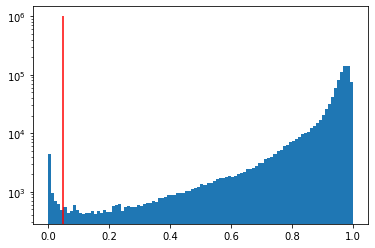

In [12]:
_=plt.hist(chi2_test[1],bins=100)
plt.vlines(0.05,0,1e6,'r')
plt.yscale('log')

In [14]:
useful_features=features[useful_id]

In [19]:
len(features)

964499

In [20]:
len(useful_features)

7230

In [15]:
clf_l1_2=LogisticRegression(penalty='l2',C=1,random_state=0,solver='liblinear')
clf_l1_2.fit(xtrain_tfv[:,useful_id],train['Verdict'])
predictions=clf_l1_2.predict(xtest_tfv[:,useful_id]) 
precision_recall_fscore_support(test['Verdict'], predictions, average='macro')

(0.732947906222844, 0.7173333333333333, 0.7066211605744713, None)

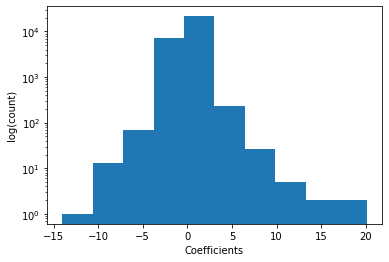

In [16]:
plt.hist(clf_l1_2.coef_.ravel())
plt.yscale("log")
plt.ylabel("log(count)")
plt.xlabel("Coefficients")
plt.savefig("coefficients.png")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


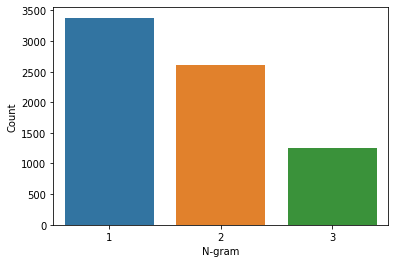

In [17]:
import seaborn as sns
#ax=plt.subplots()
ngrams_count1=list(map(lambda x: len(str(x).split(" ")),useful_features))
ngrams_count2=list(map(lambda x: len(str(x).split(" ")),features))

sns.countplot(ngrams_count1)#,palette=sns.color_palette('deep'))
#sns.countplot(ngrams_count2,palette=sns.color_palette('pastel'))
plt.ylabel('Count')
plt.xlabel('N-gram')
#plt.yscale('log')
plt.savefig('ngram-count.png')

In [18]:
for i in range(4):
    print(list(zip(
        useful_features[np.argsort(clf_l1_2.coef_[i])[-100:]][::-1],
    clf_l1_2.coef_[i][np.argsort(clf_l1_2.coef_[i])[-100:]][::-1])))

[('monday', 19.78502592638121), ('added', 15.24193166240525), ('reportedly', 11.864478717987092), ('press', 10.129495253358073), ('adding', 9.767478890331391), ('confirmed', 9.246600636389248), ('tuesday', 8.77750915473408), ('source', 6.634352506999368), ('announced', 6.478339355229991), ('reporter', 6.447656037038637), ('source confirmed', 6.269570643124704), ('resident', 6.136690612701703), ('noting', 5.883586117206682), ('told reporter', 5.329505158215553), ('im', 4.980410950155023), ('really', 4.8949016377299195), ('shit', 4.677478505009856), ('announced monday', 4.587689416456673), ('hour', 4.5290420732226595), ('pretty', 4.5263106530333985), ('citizen', 4.49772007178092), ('mr', 4.487581653121498), ('expressed', 4.467693292468413), ('fucking', 4.366696860365769), ('president bush', 4.0857695690475), ('source reported', 4.030212841881082), ('noted', 3.9813059466559917), ('continued', 3.9653593535940392), ('dr', 3.9621682639693487), ('week', 3.8754762366693347), ('entire', 3.86711